In [1]:
import random
import time

import gym  # OpenAI Gym库，用于创建和操作环境
import numpy as np  # NumPy库，用于进行数值计算
import matplotlib.pyplot as plt # Matplotlib的pyplot，用于绘图
import torch as torch

import os   # os库，用于处理操作系统相关的任务，如环境变量设置
os.environ['SDL_VIDEODRIVER'] = 'dummy' # 设置环境变量，尝试在没有显示设备的情况下运行Gym环境

from IPython.display import clear_output    # 用于清除输出

In [2]:
env = gym.make('CartPole-v1')   # 创建环境

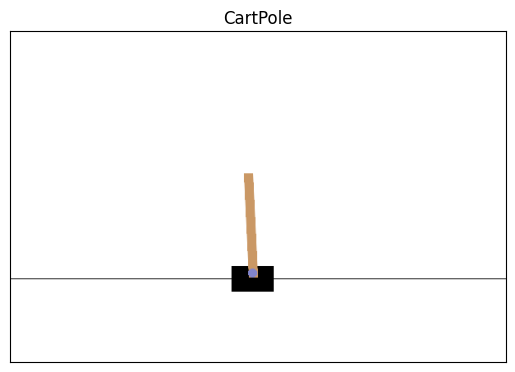

In [3]:
env.reset() # 重置环境并获取初始屏幕渲染
screen = env.render('rgb_array')    # 使用'rgb_array'模式进行渲染，获取当前图像
screen = np.ascontiguousarray(screen,dtype=np.float32)/255. # 将图像数组转换为连续的浮点数数组，并进行归一化

plt.figure()    # 绘制当前屏幕图像
plt.imshow(screen)  # 使用imshow函数显示图像
plt.title('CartPole')   # 设置图像标题
plt.xticks([])  # 隐藏x轴刻度
plt.yticks([])  # 隐藏y轴刻度
plt.show()  # 显示图像

In [4]:
# 定义一个函数，用于绘制结果
def plot_result(values, title=''):
    clear_output(True)  # 清除当前输出
    f, ax = plt.subplots(1,2,figsize=(12,5))    # 创建一个1x2的子图布局，并设置总体尺寸
    f.suptitle(title)   # 设置总体标题

    # 在第一个子图中，绘制每个episode的奖励
    ax[0].plot(values, label='rewards per episode')
    ax[0].axhline(200, c='red', label='goal')   # 绘制目标线
    ax[0].set_xlabel('Episode') # 设置x轴标签
    ax[0].set_ylabel('Reward')  # 设置y轴标签
    ax[0].legend()  # 显示图例

    # 在第二个子图中，绘制最后50个episode的奖励分布
    ax[1].set_title('mean reward = {}'.format(sum(values[-50:])/50))    # 设置标题为平均奖励值
    ax[1].hist(values[-50:], label='rewards count')    # 绘制直方图
    ax[1].axvline(200,c='red',label='goal') # 绘制目标线
    ax[1].set_xlabel('Reward per Last 50 Episodes') # 设置x轴标签
    ax[1].set_ylabel('Requency')    # 设置y轴标签
    ax[1].legend()  # 显示图例

    plt.show()  # 显示图像

# 定义一个随机策略函数，执行指定次数的episode
def random_policy(env, episodes):
    rewards = []    # 创建一个空列表，用于存储每个episode的总奖励
    for _ in range(episodes):
        env.reset()
        total_reward = 0
        done = False

        while not done :
            action = env.action_space.sample()  # 从动作空间中随机选取一个动作
            next_state,reward,done,_ = env.step(action) # 执行动作，并获取下一状态、奖励和结束标志
            total_reward += reward  # 累加奖励
        rewards.append(total_reward)    # 将本episode的总奖励添加到列表中
        plot_result(rewards)    # 绘制结果

# random_policy(env,50)

In [5]:
class DQN():
    # 初始化函数，定义了网络结构，损失函数以及优化器
    def __init__(self, state_dim:int, action_dim:int, hidden_dim=64, lr=0.001): #状态空间大小，动作空间大小，隐藏层神经网络大小，学习率lr
        self.model = torch.nn.Sequential(   # 创建神经网络，包含两个隐藏层和LeakyReLU激活函数
            torch.nn.Linear(state_dim,hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim,hidden_dim*2),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim*2,action_dim)
        )
        self.criterion = torch.nn.MSELoss() # 定义损失函数为均方误差损失
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=lr)    # 定义优化器为Adam，学习率为lr

    # 更新网络的函数，输入为状态和Q值，计算损失并反向传播
    def update(self, state:np.ndarray, q:np.ndarray):
        # 预测Q值
        q_pred = self.model(torch.Tensor(state))
        # 计算预测Q值和实际Q值的均方误差损失
        loss = self.criterion(q_pred, torch.Tensor(q))
        # 清零梯度
        self.optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 更新网络参数
        self.optimizer.step()

    # 预测函数，输入为状态，输出为预测的Q值
    def predict(self, state:np.ndarray)-> torch.Tensor:
        # torch.no_grad()表示不需要计算梯度，不会进行反向传播
        with torch.no_grad():
            # 返回预测的Q值
            return self.model(torch.Tensor(state))

In [6]:
# 简单的DQN训练函数, 训练环境env，训练轮数episodes，衰减因子gamma为0.9，随机概率epsilon，衰减率epsilon_decay
def dqn_simple(env, model, episodes, gamma=0.9, epsilon=0.3, epsilon_decay=0.9, title='dqn_simple'):
    # 初始化奖励列表
    rewards = []
    # 对每个episode进行循环
    for _ in range(episodes):
        # 重置环境，获取初始状态
        state = env.reset()
        # 初始化总奖励
        total_reward = 0.
        # 初始化结束标志
        done = False
        # 当episode没有结束时
        while not done:
            # epsilon-greedy策略，有epsilon的概率选择随机动作
            if(random.random() < epsilon):
                action = env.action_space.sample()
            else:
                # 否则选择Q值最大的动作
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
            # 执行动作，获取下一状态，奖励和是否结束，并累加奖励
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            # 计算Q值，如果episode结束则只考虑即时奖励，否则考虑即时奖励和下一状态的最大Q值乘以衰减因子gamma
            q_values = model.predict(state)
            q_values[action] = (
                reward + (0 if done else gamma * torch.max(model.predict(next_state)).item())
            )
            # 根据新的Q值更新网络
            model.update(state, q_values)
            # 更新状态
            state = next_state

        # 每轮结束后衰减epsilon，但最小值不低于0.01
        epsilon = max(epsilon * epsilon_decay, 0.01)
        # 将总奖励加入到奖励列表中
        rewards.append(total_reward)
        # 绘制奖励曲线
        plot_result(rewards)

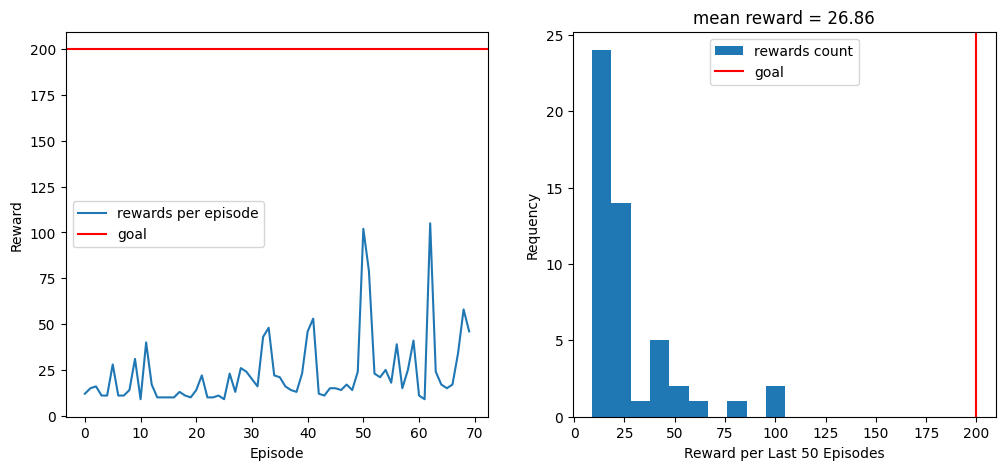

KeyboardInterrupt: 

In [7]:
simple_dqn = DQN(state_dim=4, action_dim=2, hidden_dim=64, lr=0.001)
# 用simple_dqn模型训练环境env，训练轮数为2000，衰减因子gamma为0.9，epsilon初始值为0.5，epsilon衰减率为0.99
dqn_simple(env=env, model=simple_dqn, episodes=150, gamma=0.9, epsilon=0.5, epsilon_decay=0.99)


## simple DQN

$$
\begin{align}\pi(s) = \arg\!\max_a \ Q(s, a)\end{align}
$$